In [1]:
# Note: in practice, one should put all the imports at the top of a Python script. 
# But for educational purposes here, I put the import immediately before usage. 
# This Python block is just to set up some plotting stuff.

# Imports for plotting
%matplotlib inline
import openpathsampling as paths
import numpy as np
from toy_plot_helpers import ToyPlot
plot = ToyPlot()

# Obtaining the first trajectories for a Toy Model

This example shows how to set up a RETIS calculation. We do this on a simple 2D model so it can be fast enough for an interactive example, but the basic approach applies to larger systems as well. Although I'll describe everything here in terms of 2-state systems, all the ideas generalize when setting up multiple-state systems (you just need to find more initial paths).

## Getting an initial path

RETIS is a path sampling method: it requires that the user supply an input path for each path ensemble. This means that you must somehow generate a first input path. In general, getting the first input paths for RETIS boils down to solving two problems:

1. Getting a trajectory that samples the rare event.
2. Filling all the path ensembles with acceptable trajectories.

Since transition paths satisfy all the path ensembles between two states, a common approach is to use the same initial path for all path ensembles (reversing it where necessary). This way, once you've solved problem 1, problem 2 is trivial.

The first rare path can come from any number of sources. The obvious approach might be to find a transition path from a committor analysis, because this would give you a path that satisfies the true dynamics. However, the initial path doesn't need to satisfy the true dynamics of the system (later we will equilibrate the path ensemble anyway). This means that other approaches, such as high-temperature trajectories, can be used for the first path. One of the most widely-used methods to get an initial trajectory is to generate a transition trajectory using metadynamics. However, the downside of using paths that don't satisfy the true dynamics is that it might be harder to get them to equilibrate to the correct path ensemble. It seems that this has been more of a problem with paths from high temperature runs than with paths from metadynamics: a path from a modified potential energy surface at the correct temperature seems to equilibrate more easily than a path from the original potential energy surface at an incorrect temperature.

In this example, we use a bootstrapping approach, which does create paths satisfying the true dynamics of the system. This bootstrapping is nice because it is quick and convenient, although it works best on smaller systems with less complicated transitions. It works by running normal MD to generate a path that satisfies the innermost interface, and then performing shooting moves in that interface's path ensemble until we have a path that crosses the next interface. Then we switch to the path ensemble for the next interface, and shoot until the path crossing the interface after that. The process continues until we have paths for all interfaces.

### Basic system setup

First we set up our system: for the toy dynamics, this involves defining a potential energy surface (PES), setting up an integrator, and giving the simulation an initial configuration. In real MD systems, the PES is handled by the combination of a topology file and a force field definition, and the initial configuration would come from a file instead of being described by hand.

In [2]:
import openpathsampling.toy_dynamics as toy 
#import logging.config
#logging.config.fileConfig("logging.conf", disable_existing_loggers=False)

### Set up the toy system
This includes the potential energy surface (PES), and an initial configuration

In [3]:
# Toy_PES supports adding/subtracting various PESs. The OuterWalls PES type gives an x^6+y^6 boundary to the system
pes = (toy.OuterWalls([1.0, 1.0], [0.0, 0.0]) + 
       toy.Gaussian(2.0, [1.0, 4.0], [0.0,1.0]) + 
       toy.Gaussian(2.0, [25.0, 1.0], [0.0, -1.0])
      )
topology=paths.ToyTopology(
    n_spatial = 2,
    masses =[1.0, 1.0],
    pes = pes
)
initial_snapshot = paths.Snapshot(
    coordinates=np.array([[-0.5, 0.0]]), 
    velocities=np.array([[0.0,0.0]]),
    potential_energy = 0.0, # Important to set energies dimensionless otherwise kcal/mol is default
    kinetic_energy = 0.0,
    topology=topology
)

### Setup engine

In [4]:
integ = toy.LangevinBAOABIntegrator(dt=0.02, temperature=0.1, gamma=1.0)
options={'integ' : integ,
         'n_frames_max' : 5000,
         'nsteps_per_frame' : 10
        }
sim = toy.ToyEngine(
        options=options,
        template=initial_snapshot
)

sim.current_snapshot = initial_snapshot

Now let's take a look at our PES and our initial configuration:

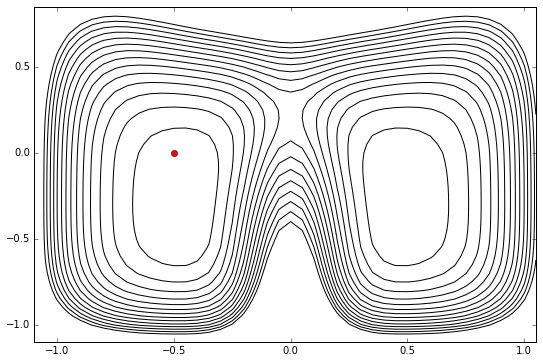

In [5]:
plot.add_pes(pes)
plot.add_initial_condition(sim.current_snapshot)
plot.plot()

### Interface setup

One downside of the bootstrapping approach is that we need to have defined our interfaces before we start. However, we can always easily change our initial interface guesses.

We'll consider a couple different choices of order parameter to define our interfaces. First we'll look at lines at different values of $x$. That set will be called `line_set`. Later we'll also consider circles centered on (-0.5, -0.25), with different radii. We'll call this set of interfaces `circle_set`. 

In both cases, we need to define the order parameter, and then we need to create a set of volumes and a set of ensembles associated with those volumes.

In [6]:
from openpathsampling.volume import VolumeFactory as vf

try:
    op_line = paths.CV_Function(name="xval", 
                                fcn=lambda snap : snap.coordinates[0,0])
except ValueError:
    print "xval already made"
# this defines a set of LambdaVolumes for which the minimum is -1.0 and the maximum is given in the array
line_volume_set = vf.LambdaVolumeSet(op_line, minvals=-1.0, maxvals=[-0.30, -0.25, -0.20, -0.13, -0.05, 0.0])
#line_volume_set = vf.LambdaVolumeSet(op_line, minvals=-1.0, maxvals=[-0.30, -0.275, -0.25, -0.225])
stateA = paths.LambdaVolume(op_line, -1.0, -0.3)
stateB = paths.LambdaVolume(op_line, 0.3, 1.0)

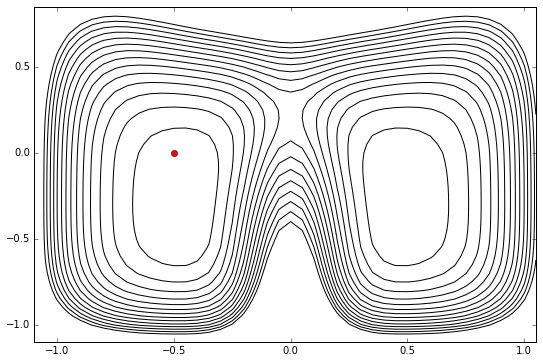

In [7]:
#plot.add_states([stateA, stateB])
#plot.add_interfaces(line_volume_set)
plot.plot()

In this picture, the states are marked in blue, and the interfaces are drawn as red lines. The initial configuration is still the red dot.

### First innermost interface path

Now we have to create an initial path. This initial path shoud exit the state, cross the first interface, and then return to the state. We'll create this path by defining a special ensemble that, propagating forward from any initial snapshot, ends when the path ends with a segment in the appropriate interface.

In [8]:
from openpathsampling.ensemble import EnsembleFactory as ef
from openpathsampling.ensemble import LengthEnsemble, AllInXEnsemble, AllOutXEnsemble, SequentialEnsemble, OptionalEnsemble, SingleFrameEnsemble

interface0 = line_volume_set[0]
first_traj_ensemble = SequentialEnsemble([
    OptionalEnsemble(AllOutXEnsemble(stateA)),
    AllInXEnsemble(stateA),
    OptionalEnsemble(AllOutXEnsemble(stateA) & AllInXEnsemble(interface0)),
    OptionalEnsemble(AllInXEnsemble(interface0)),
    AllOutXEnsemble(interface0),
    OptionalEnsemble(AllOutXEnsemble(stateA)),
    SingleFrameEnsemble(AllInXEnsemble(stateA))
])

This ensemble is a bit complicated, but works in the general case. To understand it, we'll look at the `SequentialEnsemble` segment by segment. One preliminary point is that we need the generated path ensemble to be the same as the accepted path ensemble in this case, meaning that we must define the ensemble entirely in terms of which volumes each segment is in (i.e., using `AllInXEnsemble` and `AllOutXEnsemble`, but not `PartOutXEnsemble` or `PartInXEnsemble`).

Start with the first two segments: we start with an optional ensemble outside the state, and then move to an ensemble that is in the state. Since our TIS segment must start in a state, these two ensembles allow us to either start outside the state and then evolve into the state, or to start inside the state. At the end of these two segments, we have the first frame of the TIS ensemble segment, i.e., the frame inside the state that begins the TIS path.

Next we have a couple of optional ensembles, followed by an ensemble requiring the segment to be outside the interface. The optional interfaces here are only important if `stateA` and `interface0` represent different volumes. If they represent the same volume (which is the case here) these optional ensembles don't matter. However, if they are different volumes, then there is a space which is outside the state but inside the interface. So the first optional interface represents that space. The next optional interface says that you must then be inside `interface0`: this is in case there is a reentry into the state before you cross the interface. Next, we require that we cross the interface. The last optional ensemble is for segments ouside the state. If there is space between the interface and the state, then after you are no longer outside the interface you might still be outside the state. Finally, the path ends with one frame in the state.

Following the logic of that, any path that begins anywhere and ends with a segment satisfying the innermost TIS ensemble will be accepted by this ensemble. Furthermore, since the ensemble is defined exclusively in terms of `AllInXEnsemble`s and `AllOutXEnsemble`s, the ensemble of paths generated by forward dynamics (`can_append`) is equivalent to the accepted path ensemble.

In [9]:
#%%prun -s cumulative
sim.initialized = True
first_traj = sim.generate(sim.current_snapshot, [first_traj_ensemble.can_append])

Next we use the `Ensemble.split` function to split the trajectory we found into segments satisfying the innermost interface TIS ensemble. There is only one such segment, and so we assign the first (and only) one found to `subtraj`, which is the first trajectory satisfying the innermost TIS interface.

In [10]:
paths.SampleGenerator.engine = sim
tis_trans = paths.TISTransition(stateA, stateB, line_volume_set, orderparameter=op_line, name="A->B")

In [11]:
subtraj = tis_trans.ensembles[0].split(first_traj)[0]

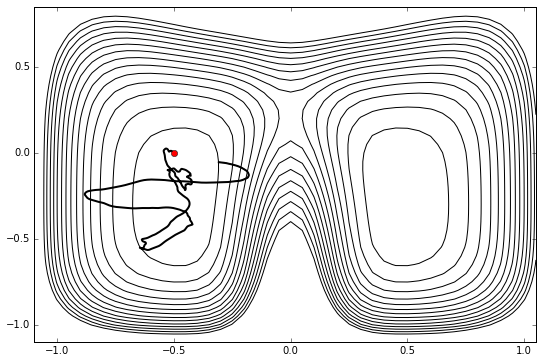

In [12]:
plot.plot(bold=[first_traj], trajectories=[subtraj])

Now we see how the initial path evolves on this surface. The last part of the trajectory, which satisfies the path ensemble for the innermost interface, is highlighted in red. The whole trajectory is drawn in black.

### Bootstrapping

The bootstrapping approach takes a single trajectory which satisfies the innermost interface, and does shooting moves until it satisfies the next ensemble. Once it satisfies the next ensemble, we start shooting from within that ensemble. We keep building up like that until all ensembles have an initial path.

To do this, we need to first create the appropriate shooting movers (one for each path ensemble). This is done quickly and efficiently with a factory function.

In [13]:
from openpathsampling.pathmover import PathMoverFactory as mf
from openpathsampling.shooting import UniformSelector

# might be nice to get rid of these two lines somehow
from openpathsampling.pathmover import PathMover

shooting_movers = tis_trans.movers['shooting']

Next we need to set up the Bootstrapping calculation:

In [14]:
store_bootstrap = paths.storage.Storage("toy_bootstrap.nc", "w", template=initial_snapshot)
bootstrap = paths.Bootstrapping(storage=store_bootstrap,
                          engine=sim,
                          ensembles=tis_trans.ensembles,
                          movers=shooting_movers,
                          trajectory=subtraj)

Now we run the bootstrapping. The number `50` means that we'll allow up to 50 shooting attempts per interface; if it takes more than that, you should probably adjust your interfaces (there's probably not much overlap for replica exchange).

In [15]:
import sys
while (len(bootstrap.globalstate) < 6):
    print len(bootstrap.globalstate), "samples so far"
    sys.stdout.flush()
    bootstrap.run(10)

1 samples so far
3 samples so far
3 samples so far
3 samples so far
3 samples so far
3 samples so far
3 samples so far
3 samples so far
3 samples so far
3 samples so far
3 samples so far
3 samples so far
3 samples so far
4 samples so far
4 samples so far
4 samples so far
4 samples so far
4 samples so far
4 samples so far
5 samples so far
5 samples so far


We've stored all the trajectories we generated here; now we want to extract a path for each ensemble to use as a starting point for TIS. We'll choose to take the first path that satisfied each ensemble.

In [16]:
print "[ ",
for sample in bootstrap.globalstate:
    print str(sample.replica)+":"+str(sample.trajectory)+" ",
print "]"

[  0:Trajectory[32]  1:Trajectory[37]  2:Trajectory[33]  3:Trajectory[47]  4:Trajectory[52]  5:Trajectory[51]  ]


Let's go ahead and visualize where each of those trajectories are:

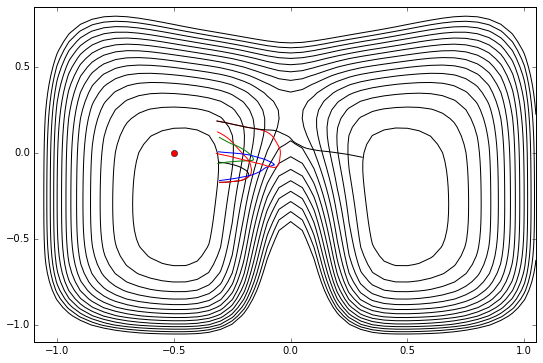

In [17]:
plot.plot([sample.trajectory for sample in bootstrap.globalstate])

In [18]:
#plot.plot([sample.trajectory for sample in equilibration.globalstate])

Rerun the last two cells a few times to see what happens as you equilibrate further.

## RETIS: Production run

With everything else set up, we can set up the replica exchange movers, and reuse the other movers.

In [19]:
#from openpathsampling.pathmover import NeighborEnsembleReplicaExchange
#repex_movers = NeighborEnsembleReplicaExchange(interface_ensemble_set)
#repex_chooser = paths.RandomChoiceMover(repex_movers, name="RepExChooser")

We'll also set up the minus ensemble and minus move:

In [20]:
#minus_ensemble = paths.MinusInterfaceEnsemble(state_vol=stateA,
#                                              innermost_vol=line_volume_set[0],
#                                              n_l=2)
#minus_move = paths.MinusMover(minus_ensemble=minus_ensemble,
#                              innermost_ensemble=interface_ensemble_set[0])

We also have to create a path which is valid for the minus ensemble. 

In [21]:
#minus_segment = equilibration.globalstate[0].trajectory
#last_frame = minus_segment[-1]
#extension = sim.generate(last_frame, [minus_ensemble.can_append])
#first_minus = minus_segment + extension[1:]
#minus_samp = paths.Sample(
#    replica=-1,
#    trajectory=first_minus,
#    ensemble=minus_ensemble,
#)
#minus_samp.details = paths.MoveDetails.initialization(minus_samp)
#start_gs = equilibration.globalstate#.apply_samples([minus_samp])

In [22]:
#plot.plot([first_minus])

Finally, we set up a production run; this is very similar to the setup for the TIS equilibration run. However, up until now, we have not used file storage; before this run we will set up a storage file. The single storage file will save all the trajectories as well as all the details of the RETIS simulation (what movers are used, the acceptance of each trial, etc.)

In [23]:
#try:
#    storage.close()
#except NameError:
#    pass # close storage if it has been opened; useful in interactive mode

#storage = paths.storage.Storage('toy_tis.nc', mode='w', template=initial_snapshot)

In [24]:
#storage.save(tis_trans)

In [25]:
#retis_root_mover = RandomChoiceMover([shooting_chooser, reversal_chooser, repex_chooser, minus_move])
#production = PathSampling(
#    storage=storage, 
#    engine=sim, 
#    root_mover=tis_trans.default_movers(sim), 
#    globalstate=start_gs
#)

We will run only TIS moves for this production.

In [26]:
#production.run(30)

While doing the production run, the results were automatically saved to the storage. We can see this by seeing how many `SampleSet`s have been saved to the `storage` object: it should equal the number of steps in the run, plus 1 for the original set.

In [27]:
#storage.samplesets.count()

In [28]:
store_bootstrap.sync()